In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
measure_columns = inspector.get_columns('measurement')
for c in measure_columns:
    print(c["name"], c["type"])
print("-------------------------")
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [16]:


# Find the date of the last day recorded in the data
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#Convert last day to an object so I can find a year previous
ld_object = datetime.strptime(last_day[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
year_ago = ld_object-dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores for the past year
full_year = session.query(Measurement.date,Measurement.prcp).filter(func.strftime("%Y-%m-%d",Measurement.date) >= year_ago ).all()

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(full_year, columns = ['date','prcp'])
# Sort the dataframe by date
df=df.sort_values('date')
#set the index to the date column
date_index_df = df.set_index('date')


<function matplotlib.pyplot.show(*args, **kw)>

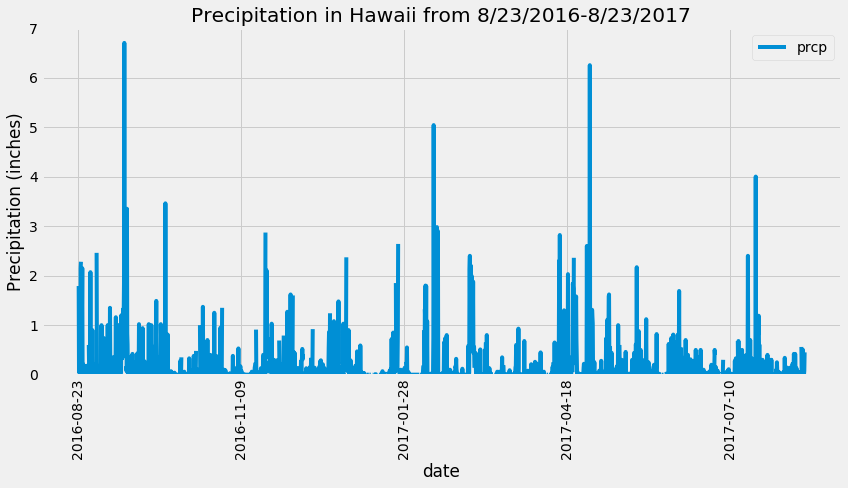

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
date_index_df.plot(title = "Precipitation in Hawaii from 8/23/2016-8/23/2017",
                   figsize = (12,7),
                   ylim =[0,7], yticks= [i for i in range(8)],
                   rot = 90)
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_index_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station).distinct(Station.station).group_by(Station.station).count()
print(num_of_stations)


9


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station = 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs).filter_by(station= 'USC00519281').filter(func.strftime("%Y-%m-%d",Measurement.date) >= year_ago).all()

[59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83]


Text(0.5, 1.0, 'Temperature Distribution')

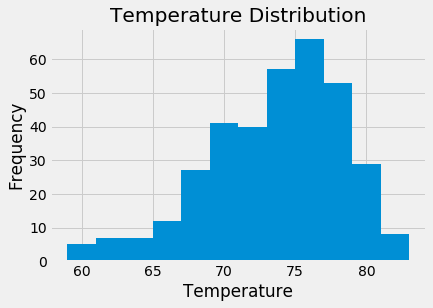

In [24]:
#create df of session query results
tobs_df = pd.DataFrame(tobs)
#Sort the df by temperature
tobs_df.sort_values('tobs')
#Plot histogram with 12 bins. Add title and labels for x-axis,y-axis.
tobs_df.hist(bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Temperature Distribution")

## Bonus Challenge Assignment

I am going to go on vacation from 3/10-3/20

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-02-28','2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = calc_temps('2017-03-10', '2017-03-20')
print(trip)

[(65.0, 71.82089552238806, 82.0)]


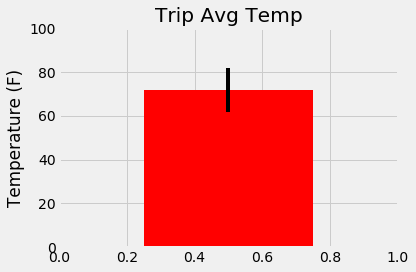

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(x=0.5, height =trip[0][1],  width = 0.5,align= 'center',color = 'red',yerr = (trip[0][2]-trip[0][1]))
plt.gca().set_ylim(0,100)
plt.gca().set_xlim(0,1)
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")

plt.tight_layout()
plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_by_st = session.query(func.sum(Measurement.prcp), Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
        filter(Measurement.date >= '2017-03-10').filter(Measurement.date <= '2017-03-20').filter(Measurement.station==Station.station).\
        group_by(Measurement.station).all()


In [29]:

df = pd.DataFrame(rain_by_st, columns = ['prcp','station','name','latitude','longitude','elevation'])
df

,prcp,station,name,latitude,longitude,elevation
0,0.35,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,0.19,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,0.00,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,0.06,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,0.24,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,0.00,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.35,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-03-10'
st_object = datetime.strptime(start_date, '%Y-%m-%d')
#end_date = '2017-03-20'
#end_obj = datetime.strptime(end_date, '%Y-%m-%d')
# Use the start and end date to create a range of dates
final_info = []
dates = []
for x in range(11):
    day =(st_object + dt.timedelta(days = x))
    
    input = day.strftime('%m-%d')
    dates.append(input)
    final_info.append(*daily_normals(input)) 
    
    
#     append({'min':more["min"],'average':more["average"],'max':more["max"]},ignore_index=True)
#     print(more["min"])
        
    
# Stip off the year and save a list of %m-%d strings
#next_day = end_obj - dt.timedelta(days = 1)
# Loop through the list of %m-%d strings and calculate the normals for each date
final_info

[(57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0),
 (62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0)]

In [32]:
dates

['03-10',
 '03-11',
 '03-12',
 '03-13',
 '03-14',
 '03-15',
 '03-16',
 '03-17',
 '03-18',
 '03-19',
 '03-20']

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_range=pd.DataFrame(final_info, columns = ['min','average','max'])
temp_range["Date"]=dates
temp_range.set_index("Date", inplace = True)

In [34]:
temp_range

,min,average,max
Date,,,
03-10,57.0,69.122807,75.0
03-11,60.0,69.892857,82.0
03-12,62.0,69.888889,80.0
03-13,56.0,69.296296,77.0
03-14,62.0,70.327586,77.0
03-15,58.0,68.547170,76.0
03-16,60.0,69.703704,78.0
03-17,57.0,68.540000,75.0
03-18,57.0,67.784314,76.0


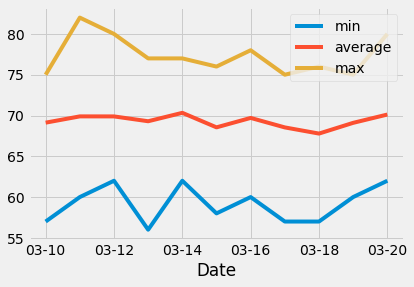

In [35]:
temp_range.plot()